# PPSeq with GPU support

The original PPSeq algorithm worked in continuous time and used a collapsed Gibbs sampler for nonparametric Bayesian inference. Unfortunately, the collapsed algorithm introduced serial dependencies that could make computation slow on some datasets. Here, we implement a simpler inference algorithm that works in discrete time takes advantage of parallelization across time bins using a GPU.


## Setup

In [1]:
try:
    import ppseq
except:
    !pip install -q git+https://github.com/lindermanlab/ppseq-pytorch.git@main
    import ppseq

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from ppseq.plotting import plot_model, color_plot
from ppseq.model import PPSeq

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print('Could not find a GPU. Defaulting to CPU instead.')

Could not find a GPU. Defaulting to CPU instead.


## Load some demo data

In [4]:
url = 'https://raw.githubusercontent.com/lindermanlab/ppseq-pytorch/main/data/songbird_spikes.txt'
df = pd.read_csv(url, delimiter='\t', header=None, names=["neuron", "time"])
list_of_spiketimes = df.groupby("neuron")["time"].apply(list).to_numpy()


bin_width = 0.1
num_timesteps = int(df["time"].max() // bin_width) + 1
num_neurons = len(list_of_spiketimes)
data = torch.zeros(num_neurons, num_timesteps, device=device)
for i, spike_times in enumerate(list_of_spiketimes):
    for t in spike_times:
        data[i, int(t // bin_width)] += 1
data = data[~torch.all(data == 0, dim=1)]

## Construct a PPSeq model

In [5]:
torch.manual_seed(0)
model = PPSeq(num_templates=2,
              num_neurons=num_neurons,
              template_duration=20)

Could not find a GPU. Defaulting to CPU instead.


In [6]:
lps, amplitudes = model.fit(data, num_iter=50)

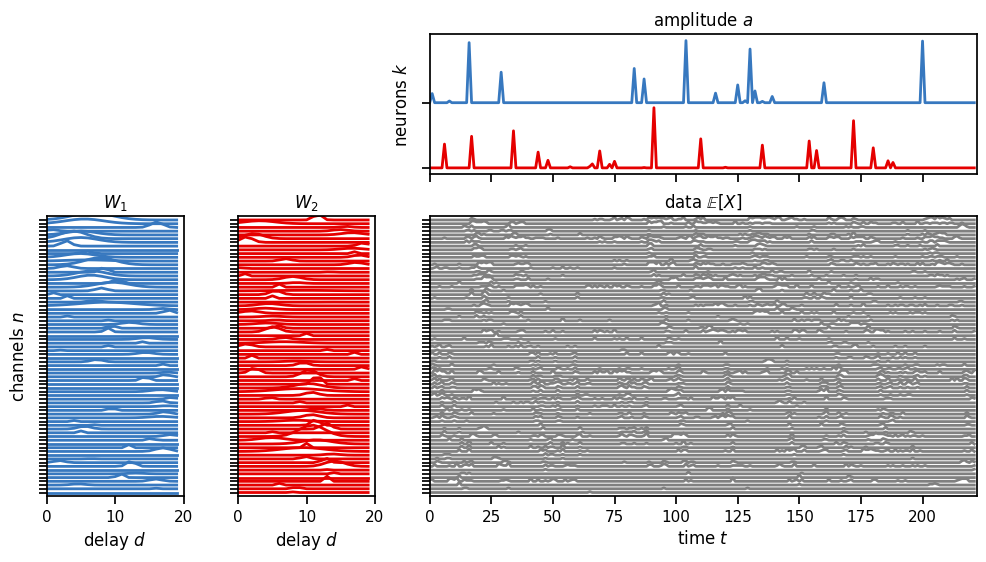

In [7]:
plot_model(model.templates.cpu(),
           amplitudes.cpu(),
           data.cpu(),
           spc=.33)

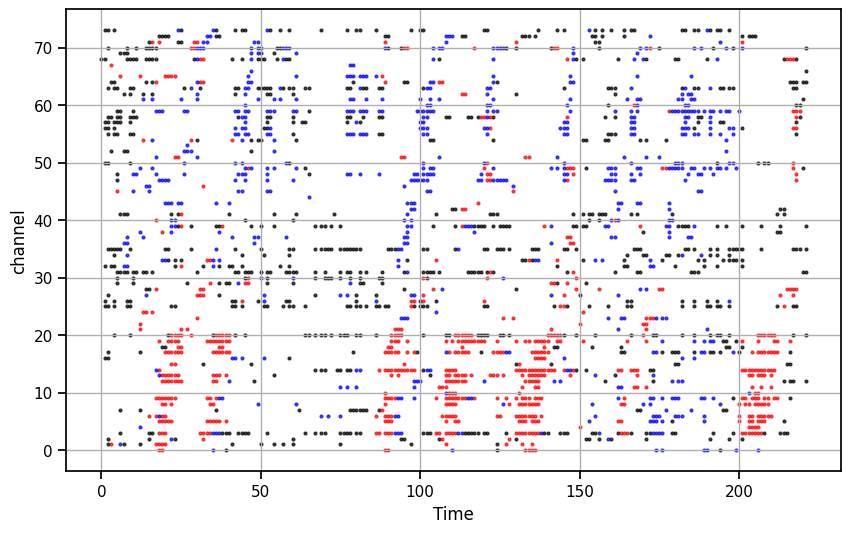

In [8]:
color_plot(data.cpu(),
           model.base_rates.cpu(),
           amplitudes.cpu(),
           model.templates.cpu(),
           model.template_scales.cpu(),
           model.template_offsets.cpu())

Text(0, 0.5, 'log likelihood')

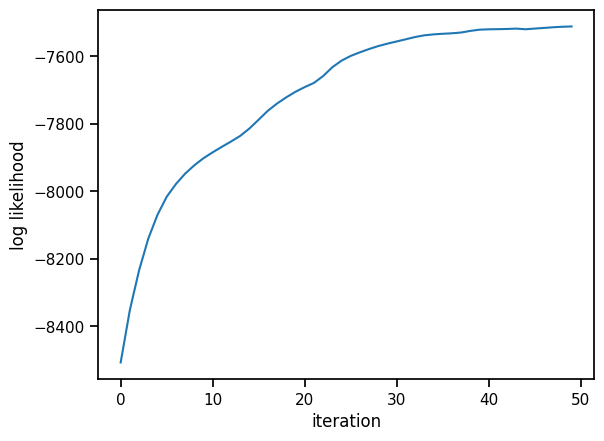

In [9]:
plt.plot(lps.cpu())
plt.xlabel("iteration")
plt.ylabel("log likelihood")

## Conclusion

This notebook is just a vanilla demonstration of how to fit a model to real data. In practice, you need to also perform some cross-validation to select the number of sequences. Stay tuned for future notebooks that demonstrate how to do so.